In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE

import joblib

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

In [4]:
#log-transform
def log_transform(X, columns):
    X = X.copy()
    for col in columns:
        X[col] = np.log(X[col] + 1e-8)
    return X

In [5]:
def update_column_names(df):
    df = df.rename(columns={
        'Temperature': 'Temperatura',
        'Humidity': 'Umidade',
        'Wind Speed': 'Velocidade_do_Vento',
        'Cloud Cover': 'Cobertura_de_Nuvens',
        'Pressure': 'Pressao',
        'Location': 'Localizacao',
        'Rain Tomorrow': 'Chovera_Amanha',
        'Precipitation': 'Precipitacao',
        'Date':'Data',
    })
    return df

In [6]:
def get_season(date):
        month = date.month
        day = date.day
        if (((month == 3 and day > 19) and (month == 6 and day < 21)) or (month == 4) or (month == 5)):
                return 'Primavera'
        elif (month == 6 or month == 7 or month == 8 or (month == 9 and day < 23)):
                return 'Verão'
        elif (month == 9 or month == 10 or month == 11 or (month == 12 and day < 21)):
                return 'Outono'
        else:
                return 'Inverno'

In [7]:
# Mapeamento completo de cidades para estados
cidade_para_estado = {
    'Los Angeles': 'California', 
    'Chicago': 'Illinois', 
    'Houston': 'Texas',
    'Phoenix': 'Arizona',
    'Philadelphia': 'Pennsylvania',
    'San Antonio': 'Texas', 
    'San Diego': 'California',
    'Dallas': 'Texas',
    'San Jose': 'California', 
    'Austin': 'Texas', 
    'Jacksonville': 'Florida', 
    'Fort Worth': 'Texas',
    'Columbus': 'Ohio', 
    'Indianapolis': 'Indiana', 
    'Charlotte': 'North Carolina', 
    'San Francisco': 'California',
    'Seattle': 'Washington', 
    'Denver': 'Colorado', 
    'New York': 'New York', 
    'Washington D.C.': 
    'District of Columbia'
}
estado_para_regiao = {
    'California': 'Oeste',
    'Illinois': 'Meio-Oeste',
    'Texas': 'Sul',
    'Arizona': 'Oeste',
    'Pennsylvania': 'Nordeste',
    'Florida': 'Sul',
    'Ohio': 'Meio-Oeste',
    'Indiana': 'Meio-Oeste',
    'North Carolina': 'Sul',
    'Washington': 'Oeste',
    'Colorado': 'Oeste',
    'New York': 'Nordeste',
    'District of Columbia': 'Sul'
}
def cidade_para_regiao(cidade: pd.Series) -> str:
    cidade = cidade.title()
    estado = cidade_para_estado.get(cidade)
    return estado_para_regiao.get(estado) if estado else None

In [22]:
from imblearn.pipeline import Pipeline as ImbPipeline

numeric_features_pt = ['Temperatura', 'Umidade', 'Velocidade_do_Vento', 'Cobertura_de_Nuvens', 'Pressao', 'Dia', 'Mes', 'Ano']

categorical_features_pt = [
    # 'Estacao', 
    'Regiao']

def pre_processar_df(df: pd.DataFrame, numeric_columns):
    # Transformando os dados numéricos para o log

    # Cria a coluna Estacao
    df['Data'] = pd.to_datetime(df['Data'])
    
    df.sort_values(by='Data', inplace=True, ascending=True)
    
    df['Ano'] = df['Data'].dt.year
    df['Mes'] = df['Data'].dt.month
    df['Dia'] = df['Data'].dt.day
    
    
    # # Cria a coluna Estacao
    # df["Estacao"] = df["Data"].apply(get_season)
    
    # Cria a coluna Regiao
    df['Regiao'] = df['Localizacao'].apply(cidade_para_regiao)

    # Remove colunas originais que não serão mais usadas
    df = log_transform(df, numeric_columns)
    df = df.drop(['Data', 'Localizacao'], axis=1)
    return df

# Para usar no pipeline:
preprocess_func = FunctionTransformer(pre_processar_df, kw_args={'numeric_columns': numeric_features_pt}, validate=False)


preprocess_before_transforms_pipeline = Pipeline([
    ('preprocess_func', preprocess_func)
])

numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Preprocessamento
# Cria o pré-processador

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features_pt),
    ('cat', categorical_transformer, categorical_features_pt)
], remainder='passthrough')

preprocessor_without_scaling = ColumnTransformer([
    ('cat', categorical_transformer, categorical_features_pt)
], remainder='passthrough')


# Criando as pipelines
pipeline_sem_scaling = ImbPipeline([
    ('preprocess_func', preprocess_func),
    ('preprocessor', preprocessor_without_scaling),
    ('smote', SMOTE())
])

pipeline = ImbPipeline([
    ('preprocess_func', preprocess_func),
    ('preprocessor', preprocessor),
    ('smote', SMOTE())
])

search_spaces_logistic = {
    'classifier__C': Real(1e-3, 1.0, prior='log-uniform'),
    'classifier__max_iter': Integer(100, 1000),
}

search_spaces_random_forest = {
    'classifier__n_estimators': Integer(50, 100),
    'classifier__max_depth': Integer(2, 10),
    'classifier__bootstrap': Categorical([True, False])
}

search_spaces_decision_tree = {
    'classifier__criterion': Categorical(['gini', 'entropy']),
    'classifier__splitter': Categorical(['best', 'random'])
}

search_spaces_knn = {
    'classifier__n_neighbors': Integer(1, 10),
    'classifier__weights': Categorical(['uniform', 'distance']),
    'classifier__algorithm': Categorical(['auto', 'ball_tree', 'kd_tree'])
}

search_spaces_sgd = {
    'classifier__loss': Categorical(['hinge', 'log_loss', 'squared_hinge', 'modified_huber']),
    'classifier__penalty': Categorical(['l2', 'l1', 'elasticnet']),
    'classifier__alpha': Real(1e-5, 1e-1, prior='log-uniform')
}

search_spaces_ridge_classifier = {
    'classifier__alpha': Real(1e-5, 1e-1, prior='log-uniform'),
    'classifier__solver': Categorical(['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']),
    'classifier__max_iter': Integer(100, 1000),
}

In [23]:
# Carregar dados para pipeline e vizualiuzação do durante o notebook
df_to_pipeline_use = pd.read_csv('usa_rain_prediction_dataset_2024_2025.csv')  # Substitua com o caminho correto
df_to_pipeline_use = update_column_names(df_to_pipeline_use)
print(df_to_pipeline_use.head())

         Data Localizacao  Temperatura    Umidade  Velocidade_do_Vento  \
0  2024-01-01    New York    87.524795  75.655455            28.379506   
1  2024-01-02    New York    83.259325  28.712617            12.436433   
2  2024-01-03    New York    80.943050  64.740043            14.184831   
3  2024-01-04    New York    78.097552  59.738984            19.444029   
4  2024-01-05    New York    37.059963  34.766784             3.689661   

   Precipitacao  Cobertura_de_Nuvens      Pressao  Chovera_Amanha  
0      0.000000            69.617966  1026.030278               0  
1      0.526995            41.606048   995.962065               0  
2      0.916884            77.364763   980.796739               1  
3      0.094134            52.541196   979.012163               0  
4      1.361272            85.584000  1031.790859               0  


Temperatura            408.274078
Umidade                532.045646
Velocidade_do_Vento     75.146854
Precipitacao             0.225466
Cobertura_de_Nuvens    675.089622
Pressao                408.197117
Chovera_Amanha           0.171832
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Data                 73100 non-null  object 
 1   Localizacao          73100 non-null  object 
 2   Temperatura          73100 non-null  float64
 3   Umidade              73100 non-null  float64
 4   Velocidade_do_Vento  73100 non-null  float64
 5   Precipitacao         73100 non-null  float64
 6   Cobertura_de_Nuvens  73100 non-null  float64
 7   Pressao              73100 non-null  float64
 8   Chovera_Amanha       73100 non-null  int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 5.0+ MB
None
        Temperatura   

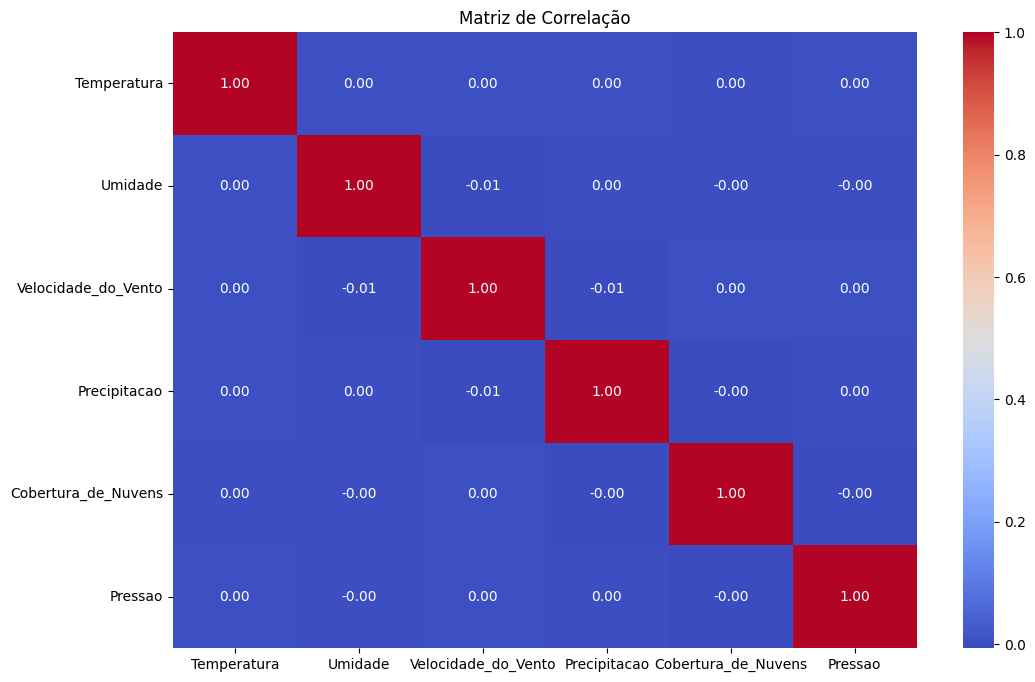

In [24]:
print(df_to_pipeline_use.var(numeric_only=True))
print(df_to_pipeline_use.info())
print(df_to_pipeline_use.describe())
print(df_to_pipeline_use.isnull().sum())

plt.figure(figsize=(12, 8))
sns.heatmap(df_to_pipeline_use.drop(['Chovera_Amanha'], axis=1).corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size":10})
plt.title('Matriz de Correlação')
plt.show()


In [26]:
import sklearn


def avaliar_modelos_pipeline(X_train, X_test, y_train, y_test, search_spaces, modelo: sklearn.base.BaseEstimator = LogisticRegression, scaled=False): 
    pipeline_a_ser_usada = pipeline_sem_scaling if not scaled else pipeline
    if pipeline_a_ser_usada.get_params().get('classifier') is not None:
        pipeline_a_ser_usada.set_params(classifier=modelo)
    else:
        pipeline_a_ser_usada.steps.append(('classifier', modelo))
    
    bayes_search = BayesSearchCV(
        estimator=pipeline_a_ser_usada,
        search_spaces=search_spaces,
        scoring='f1',
        n_iter=1,  # Ajuste conforme o tempo disponível
        cv=3,
        n_jobs=8,
        verbose=2,
        random_state=42
    )
    print(f"Treinando com a Pipeline: {pipeline_a_ser_usada}")
    # Treina o BayesSearchCV
    bayes_search.fit(X_train, y_train)
    print(f"Melhor pontuação: {bayes_search.best_score_}")
    print(f"Melhores hiperparâmetros: {bayes_search.best_params_}")

    # Pega o melhor pipeline encontrado
    melhor_pipeline = bayes_search.best_estimator_
    
    # Faz predições com o melhor pipeline
    y_pred_train = cross_val_predict(melhor_pipeline, X_train, y_train, cv=3, n_jobs=-1)
    
    y_pred_test = melhor_pipeline.predict(X_test)

    return {
        'Modelo': type(melhor_pipeline.named_steps['classifier']).__name__ + (' (Escalado)' if scaled else ''),
        'Melhor Modelo' : melhor_pipeline,
        'Accuracy Train': accuracy_score(y_train, y_pred_train),
        'Accuracy Test': accuracy_score(y_test, y_pred_test),
        'Precision Train': precision_score(y_train, y_pred_train),
        'Precision Test': precision_score(y_test, y_pred_test),
        'Recall Train': recall_score(y_train, y_pred_train),
        'Recall Test': recall_score(y_test, y_pred_test),
        'F1 Score Train': f1_score(y_train, y_pred_train),
        'F1 Score Test': f1_score(y_test, y_pred_test),
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'Melhores Hiperparâmetros': bayes_search.best_params_
    }


In [27]:

# Separando os dados em treino e teste
print("DataFrame shape:", df_to_pipeline_use.shape)
print("First few rows of the DataFrame:\n", df_to_pipeline_use.head())

X_pipeline = df_to_pipeline_use.drop('Chovera_Amanha', axis=1)
y_pipeline = df_to_pipeline_use['Chovera_Amanha']

from statsmodels.stats.diagnostic import acorr_ljungbox

result = acorr_ljungbox(y_pipeline, lags=20)  # Substitua y pela variável target
print(result)  # Se p-valor > 0.05, não há autocorrelação


X_train_pipe, X_test_pipe, y_train_pipe, y_test_pipe = train_test_split(X_pipeline, y_pipeline, test_size=0.3, shuffle=True, stratify=y_pipeline, random_state=42)

DataFrame shape: (73100, 9)
First few rows of the DataFrame:
          Data Localizacao  Temperatura    Umidade  Velocidade_do_Vento  \
0  2024-01-01    New York    87.524795  75.655455            28.379506   
1  2024-01-02    New York    83.259325  28.712617            12.436433   
2  2024-01-03    New York    80.943050  64.740043            14.184831   
3  2024-01-04    New York    78.097552  59.738984            19.444029   
4  2024-01-05    New York    37.059963  34.766784             3.689661   

   Precipitacao  Cobertura_de_Nuvens      Pressao  Chovera_Amanha  
0      0.000000            69.617966  1026.030278               0  
1      0.526995            41.606048   995.962065               0  
2      0.916884            77.364763   980.796739               1  
3      0.094134            52.541196   979.012163               0  
4      1.361272            85.584000  1031.790859               0  
      lb_stat  lb_pvalue
1    9.701434   0.001841
2   13.300157   0.001294
3   13.656

In [28]:
# Avaliação do melhor modelo
dict_modelos_pipeline = {
    'Logistic Regression': {
        'search_spaces': search_spaces_logistic,
        'modelo': LogisticRegression()
    },
    'Random Forest': {
        'search_spaces': search_spaces_random_forest,
        'modelo': RandomForestClassifier()
    },
    'Decision Tree': {
        'search_spaces': search_spaces_decision_tree,
        'modelo': DecisionTreeClassifier()
    },
    'KNN': {
        'search_spaces': search_spaces_knn,
        'modelo': KNeighborsClassifier()
    },
    'SGD Classifier': {
        'search_spaces': search_spaces_sgd,
        'modelo': SGDClassifier()
    },
    'Ridge Classifier': {
        'search_spaces': search_spaces_ridge_classifier,
        'modelo': RidgeClassifier()
    }
}

resultados_pipeline = []
for info in dict_modelos_pipeline.values():
    resultados_pipeline.extend(
        (
            avaliar_modelos_pipeline(
                X_train_pipe,
                X_test_pipe,
                y_train_pipe,
                y_test_pipe,
                info['search_spaces'],
                info['modelo'],
                scaled=True,
            ),
            # ,
            # avaliar_modelos_pipeline(
            #     X_train_pipe,
            #     X_test_pipe,
            #     y_train_pipe,
            #     y_test_pipe,
            #     info['search_spaces'],
            #     info['modelo'],
            #     scaled=True,
            # ),
        )
    )



Treinando com a Pipeline: Pipeline(steps=[('preprocess_func',
                 FunctionTransformer(func=<function pre_processar_df at 0x0000025CA82D34C0>,
                                     kw_args={'numeric_columns': ['Temperatura',
                                                                  'Umidade',
                                                                  'Velocidade_do_Vento',
                                                                  'Cobertura_de_Nuvens',
                                                                  'Pressao',
                                                                  'Dia', 'Mes',
                                                                  'Ano']})),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Melhor pontuação: 0.28956864121458686
Melhores hiperparâmetros: OrderedDict({'classifier__alpha': 0.0004369339947510315, 'classifier__loss': 'squared_hinge', 'classifier__penalty': 'elasticnet'})
Treinando com a Pipeline: Pipeline(steps=[('preprocess_func',
                 FunctionTransformer(func=<function pre_processar_df at 0x0000025CA82D34C0>,
                                     kw_args={'numeric_columns': ['Temperatura',
                                                                  'Umidade',
                                                                  'Velocidade_do_Vento',
                                                                  'Cobertura_de_Nuvens',
                                                                  'Pressao',
                                                                  'Dia', 'Mes',
                                                                  'Ano']})),
                ('preprocessor',
                 ColumnTransformer(remainder='

In [29]:
df_resultados = pd.DataFrame(resultados_pipeline)


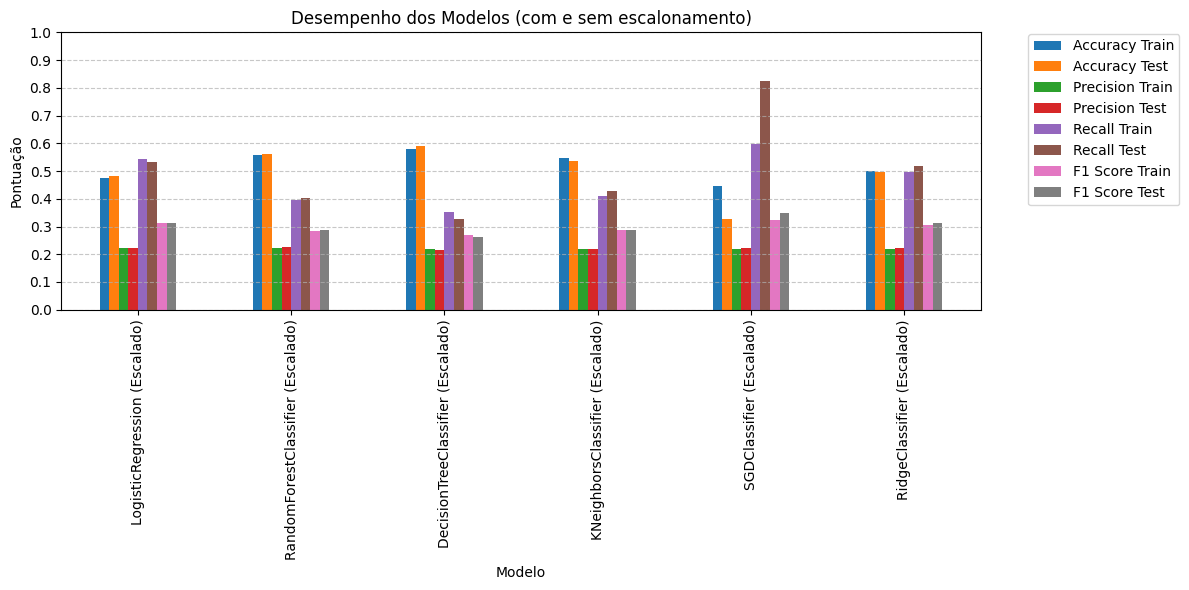

In [30]:
import matplotlib.ticker as ticker  # Importe para controlar as marcações do eixo

fig, ax = plt.subplots(figsize=(12, 6))
df_plot = df_resultados.set_index('Modelo')[[
    'Accuracy Train', 
    'Accuracy Test',
    'Precision Train',
    'Precision Test',
    'Recall Train', 
    'Recall Test',
    'F1 Score Train', 
    'F1 Score Test']]
df_plot.plot(kind='bar', ax=ax)

# Configurar marcações do eixo Y (passos de 0.1)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))  # Define intervalos de 0.1
ax.set_ylim(0, 1)  # Garante que o eixo Y vá de 0 a 1 (ajuste se necessário)

# Adicionar grid
ax.grid(True, axis='y', linestyle='--', alpha=0.7)  # Grid horizontal tracejado

# Ajustar legenda fora do gráfico
ax.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.1
)

plt.title('Desempenho dos Modelos (com e sem escalonamento)')
plt.ylabel('Pontuação')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [31]:
# Avaliação do melhor modelo
melhor_modelo = df_resultados.loc[df_resultados['F1 Score Test'].idxmax()]

print(f"Melhor modelo: {melhor_modelo['Modelo']}")
print(f"Melhor F1 Score: {melhor_modelo['F1 Score Test']}")
print(f"Melhores hiperparâmetros: {melhor_modelo['Melhores Hiperparâmetros']}")

# Exportando o melhor modelo
joblib.dump(melhor_modelo['Melhor Modelo'], 'melhor_modelo.pkl')

Melhor modelo: SGDClassifier (Escalado)
Melhor F1 Score: 0.35006820081840984
Melhores hiperparâmetros: OrderedDict({'classifier__alpha': 0.0004369339947510315, 'classifier__loss': 'squared_hinge', 'classifier__penalty': 'elasticnet'})


['melhor_modelo.pkl']

c:\Users\juand\git\faculdade\Project01-SupervisedTraining\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Acurácia no conjunto de treino: 0.4462575727965605
Acurácia no conjunto de teste: 0.3292749658002736
Precisão no conjunto de treino: 0.22135459208677755
Precisão no conjunto de teste: 0.22293922899949498
Recall no conjunto de treino: 0.600727079269374
Recall no conjunto de teste: 0.821886636326024
F1 Score no conjunto de treino: 0.32350483466634833
F1 Score no conjunto de teste: 0.3507393511366144


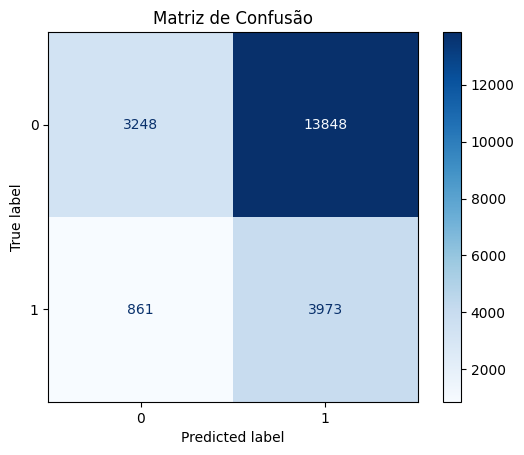

              precision    recall  f1-score   support

           0       0.79      0.19      0.31     17096
           1       0.22      0.82      0.35      4834

    accuracy                           0.33     21930
   macro avg       0.51      0.51      0.33     21930
weighted avg       0.67      0.33      0.32     21930



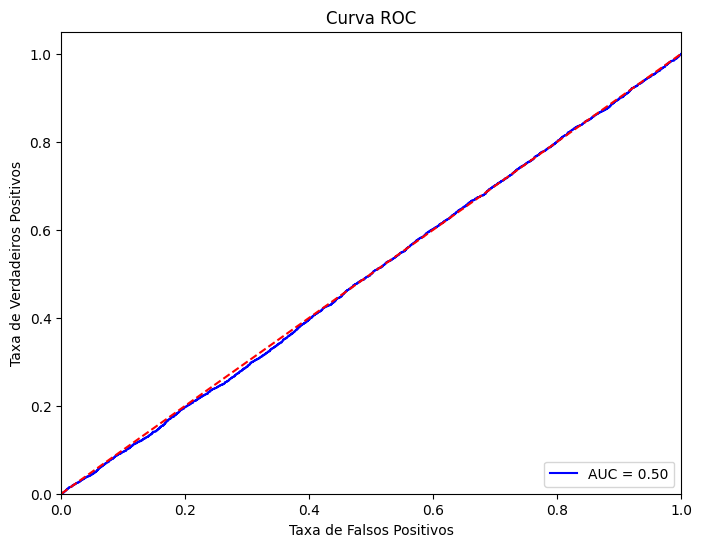

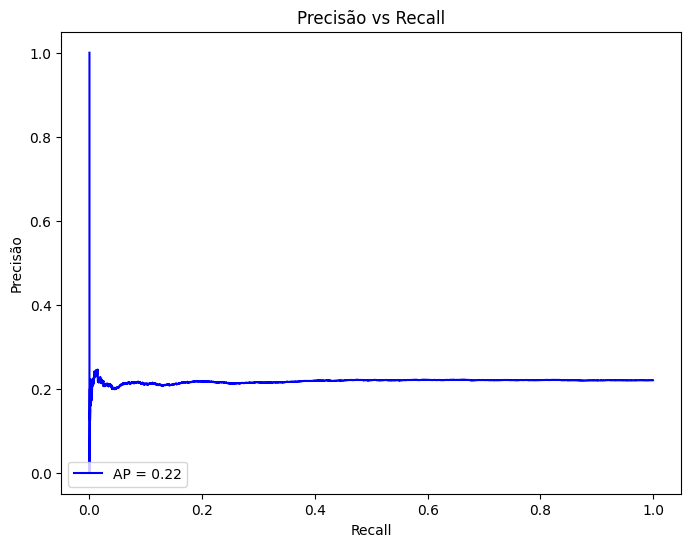

In [37]:
import joblib

modelo_final = joblib.load('melhor_modelo.pkl')
modelo_final = modelo_final.fit(X_train_pipe, y_train_pipe)

# Avaliando o modelo final
y_pred_train = cross_val_predict(modelo_final, X_train_pipe, y_train_pipe, cv=3, n_jobs=-1)
y_pred_test = modelo_final.predict(X_test_pipe)
print("Acurácia no conjunto de treino:", accuracy_score(y_train_pipe, y_pred_train))
print("Acurácia no conjunto de teste:", accuracy_score(y_test_pipe, y_pred_test))
print("Precisão no conjunto de treino:", precision_score(y_train_pipe, y_pred_train))
print("Precisão no conjunto de teste:", precision_score(y_test_pipe, y_pred_test))
print("Recall no conjunto de treino:", recall_score(y_train_pipe, y_pred_train))
print("Recall no conjunto de teste:", recall_score(y_test_pipe, y_pred_test))
print("F1 Score no conjunto de treino:", f1_score(y_train_pipe, y_pred_train))
print("F1 Score no conjunto de teste:", f1_score(y_test_pipe, y_pred_test))
# Plotando a matriz de confusão
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay


# Matriz de confusão
cm = confusion_matrix(y_test_pipe, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo_final.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.show()

# Relatório de classificação
print(classification_report(y_test_pipe, y_pred_test))
try:
    probas = modelo_final.predict_proba(X_test_pipe)[:, 1]
except AttributeError:
    probas = modelo_final.decision_function(X_test_pipe)
    
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_pipe, probas)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

# precisão vs recall
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test_pipe, probas)
average_precision = average_precision_score(y_test_pipe, probas)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label='AP = %0.2f' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Precisão vs Recall')
plt.legend(loc='lower left')
plt.show()